<a href="https://colab.research.google.com/github/MannCodes14/Pytorch-NeuralNetworks/blob/main/CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix


In [58]:
#convert mnist images files to tensor of 4 dimnesions (images, width, height, color channel)
transform = transforms.ToTensor()


In [59]:
#train data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [60]:
#test data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [61]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [62]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [63]:
#Create a small batch size for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [64]:
#creating 2 convolution layers
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

In [65]:
#Take 1 MNIST record
for i, (X_train, y_train) in enumerate(train_data):
  break

In [66]:
# y_train, X_train

In [67]:
X_train.shape

torch.Size([1, 28, 28])

In [68]:
#convert it to 4 dimension

x = X_train.view(1,1,28,28)

In [69]:
#Perform 1st Convolution
x = F.relu(conv1(x))

In [70]:
# 1 -> single image, 6 -> image filters, 26 -> width, 26 -> height
x.shape

torch.Size([1, 6, 26, 26])

In [71]:
#Pass thru Pooling layer
x = F.max_pool2d(x, 2, 2) #x -> image feature, 2 -> kernel_size, 2-> stride_size

In [72]:
x.shape # 26/2 = 13

torch.Size([1, 6, 13, 13])

In [73]:
#Do our 2nd Convolution layer
x = F.relu(conv2(x))

In [74]:
x.shape #above we havent set the padding, so there is some loss of the margin, as for now there is no crucial data at the margin so its okk :)

torch.Size([1, 16, 11, 11])

In [75]:
x = F.max_pool2d(x, 2, 2)

In [76]:
x.shape

torch.Size([1, 16, 5, 5])

In [77]:
#Creating a Model Class
class ConvolutionNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)

    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    #we need to flatten it out
    X = X.view(-1, 16*5*5)

    #send it to the NN
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)



In [78]:
#create an innstanse of the model class
torch.manual_seed(87)
model = ConvolutionNetwork()

In [79]:
model

ConvolutionNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [80]:
#Loss Opmtimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #small the learning rate, more time it will take to learn

In [81]:
import time
start_time = time.time()

#define variables for tracking

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop for epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1

    # apply model
    y_pred = model(X_train) #get predicted values from the X_train

    loss = criterion(y_pred, y_train) #Compare the predictions to correct ans
    predicted = torch.max(y_pred, 1)[1] # torch.max() returns 2 values, 1-> maximum value, 2-> the indices of the value, [1]: This indexing selects the second element returned by torch.max, which are the indices of the maximum values. These indices correspond to the predicted class labels.
    batch_corr = (predicted == y_train).sum() #how many are correct, true = 1 and false = 0, sum it and store it in the current batch
    trn_corr += batch_corr #keep track


    # update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # printout some results
    if b%600 == 0:
      print(f'epoch: {i}  batch: {b}  loss: {loss.item()}')
  train_losses.append(loss)
  train_correct.append(trn_corr)

  # test
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val, 1)[1] #torch.max() returns 2 values, 1-> maximum value, 2-> the indices of the value, [1]: This indexing selects the second element returned by torch.max, which are the indices[labels] of the maximum values. These indices correspond to the predicted class labels.
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
epoch_time = current_time - start_time
print(f'total time: {epoch_time/60} minutes')


epoch: 0  batch: 600  loss: 0.46691375970840454
epoch: 0  batch: 1200  loss: 0.01877090334892273
epoch: 0  batch: 1800  loss: 0.5251601934432983
epoch: 0  batch: 2400  loss: 0.21127578616142273
epoch: 0  batch: 3000  loss: 0.011143305338919163
epoch: 0  batch: 3600  loss: 0.0014362346846610308
epoch: 0  batch: 4200  loss: 0.0547763928771019
epoch: 0  batch: 4800  loss: 0.10175986588001251
epoch: 0  batch: 5400  loss: 0.17878961563110352
epoch: 0  batch: 6000  loss: 0.021118860691785812
epoch: 1  batch: 600  loss: 0.020726488903164864
epoch: 1  batch: 1200  loss: 0.18972620368003845
epoch: 1  batch: 1800  loss: 0.170523539185524
epoch: 1  batch: 2400  loss: 0.030440520495176315
epoch: 1  batch: 3000  loss: 0.002945380052551627
epoch: 1  batch: 3600  loss: 0.00859561376273632
epoch: 1  batch: 4200  loss: 0.0007154690101742744
epoch: 1  batch: 4800  loss: 0.06070289760828018
epoch: 1  batch: 5400  loss: 0.020454173907637596
epoch: 1  batch: 6000  loss: 0.0011517739621922374
epoch: 2  batc

In [82]:
# y_pred

In [83]:
# y_train

Text(0.5, 1.0, 'Loss')

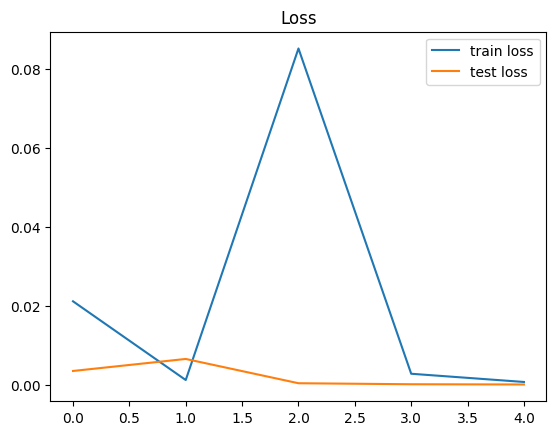

In [85]:
#convert train_losses in to python list

# to be run only once, since after that the train_losses will contain the values already
train_losses = [t.item() for t in train_losses]
test_losses = [t.item() for t in test_losses]

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

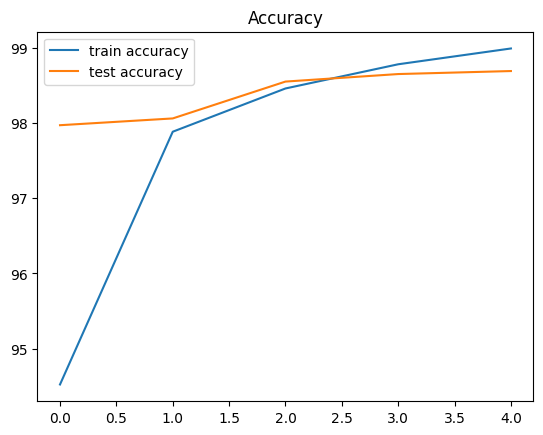

In [86]:
plt.plot([t4/600 for t4 in train_correct], label = "train accuracy")
plt.plot([t5/100 for t5 in test_correct], label = "test accuracy")
plt.legend()
plt.title("Accuracy")

In [87]:
test_load_everthing = DataLoader(test_data, batch_size=10000, shuffle=False)


In [89]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everthing:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()



In [91]:
correct.item()/len(test_data)*100

98.69

In [94]:
#Grab an image
test_data[1011][0].reshape(1,1,28,28)

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

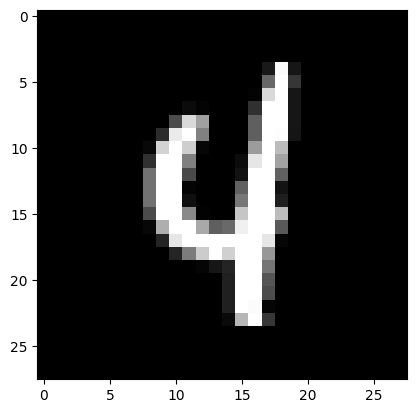

In [101]:
plt.imshow(test_data[5345][0].reshape(28,28), cmap='gray')
#

In [102]:
model.eval()
with torch.no_grad():
  newPredicted = model(test_data[5345][0].reshape(1,1,28,28))

newPredicted

tensor([[-2.0632e+01, -1.8643e+01, -1.6921e+01, -1.9257e+01, -2.2888e-05,
         -1.1962e+01, -1.2999e+01, -1.4547e+01, -1.8947e+01, -1.1192e+01]])

In [103]:
newPredicted.argmax()

tensor(4)